# Tests on .idf file manipulations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF
import seaborn as sns

## How use eppy to run EnergyPlus

The use of the `eppy` library to run an `EnergyPlus` simulation requires the same input as a conventionnal simulation:
- an `.idf` file containing the description of the building, site, schedules, HVAC, etc ...
- an `.idd` file containing the dictionary that the simulator is going to use to decode the `.idf` file. *This file is version dependent* and one should care to use the right `.idd` based on his `EnergyPlus` distribution.
- an `.epw` file, containing the weather data that will be used during the simulation. This file is mandatory to run the simulation but is optionnal if `eppy` is used to only edit `.idf` files.

In [19]:
## Define the paths to the various inputs
# Specify path to the IDF file

idf_file_path = r".\cedric\CELL.idf"

# Specify path to the IDD file
idd_file_path = r".\input_data\Energy+.idd" # Energy+ v9.4 IDD

# Specify path to the weather file
weather_file_path = r".\input_data\-_FRIBOURG_MN7.epw"

# Set the idd file
IDF.setiddname(idd_file_path)

# Create an IDF object and load the IDF file
idf = IDF(idf_file_path, weather_file_path)

Once the object is created as a python object, `eppy` provides a lot of method to programmatically access to information about the `.idf` file.

In [20]:
# Print and check the idf file is the correct one 
idf.printidf()


Version,
    9.4.0.002;                !- Version Identifier

SimulationControl,
    Yes,                      !- Do Zone Sizing Calculation
    Yes,                      !- Do System Sizing Calculation
    Yes,                      !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes;                      !- Run Simulation for Weather File Run Periods

Building,
    Building,                 !- Name
    0,                        !- North Axis
    Suburbs,                  !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

ShadowCalculation,
    PolygonClipping,          !- Shading Calculation Method
    Periodic,                 !- Shading Calculation Update

Now that our `.idf` file is loaded as an object, `eppy` provides a compact and handy way to run a simulation with `EnergyPlus`

In [9]:
## Run base simulation
# readvars = True creates a .cvs of the results
# annual = True forces the simulation to run on an annual basis

idf.run(readvars=True,output_directory=r'.\output_data', annual=True)


C:/EnergyPlusV9-4-0\energyplus.exe --weather C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\input_data\-_FRIBOURG_MN7.epw --output-directory C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\output_data --annual --idd C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\input_data\Energy+.idd --readvars C:\Users\jamil\Documents\GitHub\REHO\EnergyPlus\cedric\CELL_1fed91.idf


## Retrieve results and visualize them

The easy way to retrieve data is to use the power of Python libraries to manipulate large datasets. `Pandas` is probable the most complete and easy way to handle datasets in this range of size. The direct way is to make sure the results were generated as a `.csv` and simply load it as a `DataFrame` object. Then get back to your good old pandas habits!
Note: The timestamps of the `.csv` are not easily read and interpreted as timeseries by `Pandas`. Parsing them _à priori_ helps to correctly read the file. An adapted date parsing function resolves that, as the one proposed by [Steven Firth](https://www.stevenfirth.com/energyplus-simulation-and-analysis-using-python/) on his website. All credits to him.

In [25]:
# Steven Firth datetime parser
def parse_energyplus_datetime_string(st, year=2021):
    st=st.strip()
    month=int(st[0:2])
    day=int(st[3:5])
    hour=int(st[7:9])
    minute=int(st[10:12])
    second=(st[13:15])
    if not hour==24:
        dt=pd.Timestamp(year,month,day,hour,minute)
    else:
        hour=0
        dt=pd.Timestamp(year,month,day,hour,minute)
        dt+=pd.Timedelta('1 day')
    return dt

In [24]:
df=pd.read_csv(r".\output_data\eplusout.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )
df.head()

,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),CELLS:ROOMX1:Zone Total Internal Latent Gain Energy [J](Hourly),...,CELLS:ROOMX1:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ROOMX1:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),CELLS:ENTRANCE:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ENTRANCE:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),CELLS:ROOMX2:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ROOMX2:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),Electricity:Facility [J](Hourly),InteriorEquipment:Electricity [J](Hourly),InteriorLights:Electricity [J](Hourly),Carbon Equivalent:Facility [kg](Hourly)
Date/Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,7.500,5.300,94390.0,0.650,183.75,0.0,0.0,8.485838,-66.010149,0.0,...,0.013549,0.827465,0.014966,1.160685,0.014261,0.827421,538798.420885,5812.315488,0.0,0.0
2021-01-01 02:00:00,7.875,4.400,94328.0,0.500,232.25,0.0,0.0,36.510800,-62.284889,0.0,...,0.013549,0.827749,0.014966,1.160887,0.014261,0.827709,538798.420885,5812.315488,0.0,0.0
2021-01-01 03:00:00,7.750,3.625,94328.0,0.250,249.75,0.0,0.0,58.861858,-54.694178,0.0,...,0.013549,0.827150,0.014966,1.159841,0.014261,0.827111,538798.420885,5812.315488,0.0,0.0
2021-01-01 04:00:00,7.625,3.350,94328.0,0.425,261.00,0.0,0.0,74.726170,-45.281853,0.0,...,0.013549,0.826560,0.014966,1.158873,0.014261,0.826520,538798.420885,5812.315488,0.0,0.0
2021-01-01 05:00:00,7.525,3.150,94328.0,0.500,263.50,0.0,0.0,87.107574,-35.171794,0.0,...,0.013549,0.826022,0.014966,1.158011,0.014261,0.825984,538798.420885,5812.315488,0.0,0.0


## Modify `.idf` files using `eppy`

The first goal of this library is to programmatically access the `.idf` files and modify their content using Python. Let's see how it can be easily done.

In [10]:
zone_name = "Zone1"

# Get the Zone object
zone = idf.getobject('ZONE', zone_name)

In [11]:
heating_schedule = idf.getobject("Schedule:Compact", "Block1:Zone1 Heating Setpoint Schedule")

In [13]:
heating_schedule

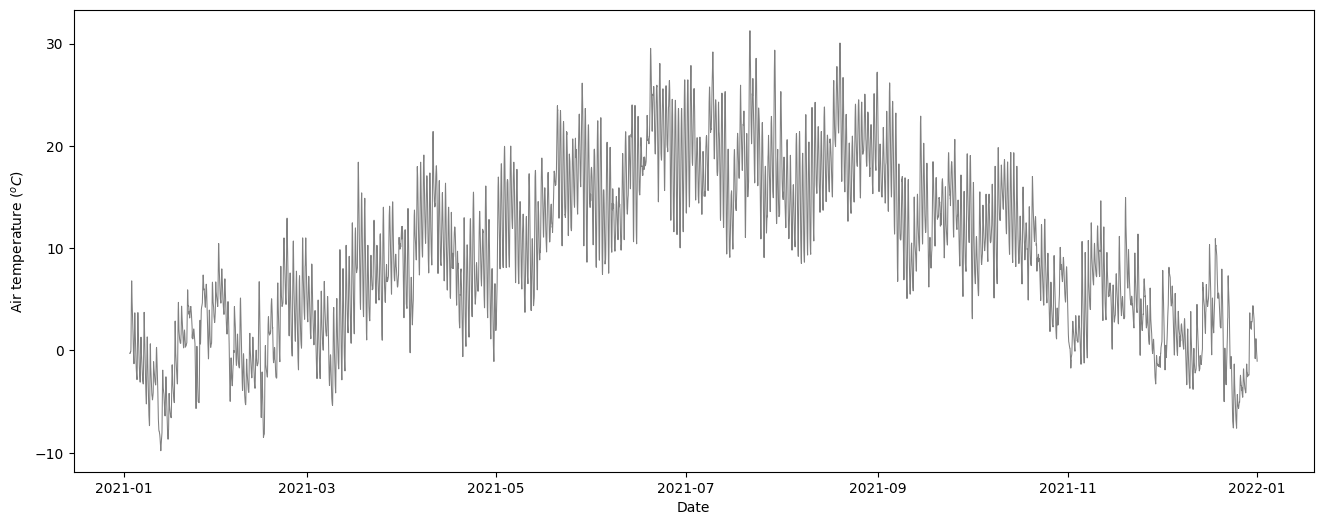

In [17]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)'][48:],  
        color='grey',
        linewidth=0.75
       )
ax.set_xlabel('Date')
ax.set_ylabel('Air temperature (${^o}C$)')  
plt.show()

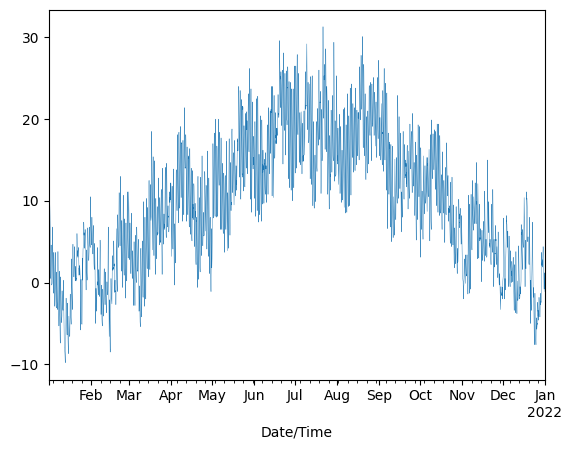

In [14]:
df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].plot(linewidth=0.3)
plt.show()

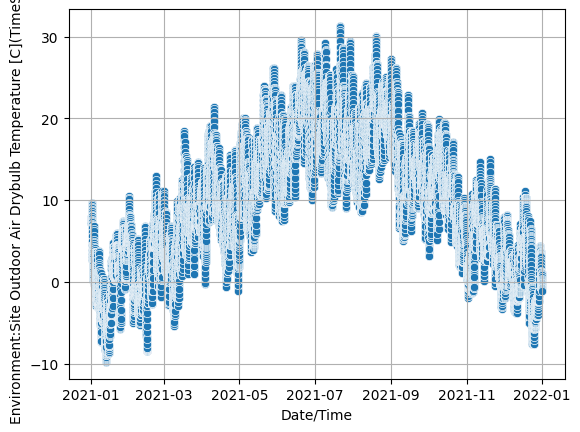

In [27]:
sns.scatterplot(data=df, x='Date/Time',y='Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)')
plt.grid()